In this notebook we will duplicate the results of the previous notebook, but in this case we will keep in mind the FAIR principles. We have placed the necessary code under the `models/model_01_CDMS-LR` directory. You can see the directory contains multiple subdirectories. This subdirectory structure is pretty common for ML repositories. The `data` subdirectory is used to locally store the data which in this case just refers to a symlink to the top level `data` dirctory for this project. The `src` subdirectory contains necessary code, in this case split across two files-

- **DataUtils.py**: Contains necessary code to load, split, and normalize the dataset
- **model.py**: Contains code to create and fit the desired model as well as perform some evaluation

You can also see some other files there which we will describe later, as we generate them. First, let's train our model.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('models/model_01_CDMS-LR/src')

from DataUtils import CDMS_DataLoader as DL
from model import CDMS_LR

In [2]:
## Get the dataset as numpy array

myDL = DL('data/CDMS_Dataset.csv', sep=',')
X_train, X_test, y_train, y_test = myDL.split_data(split_type='label', 
                                                   labels = [-12.502, -29.5, -41.9])
X_train, X_test, y_train, y_test, x_mean, x_std = myDL.normalize_data(X_train, X_test, y_train, y_test)
y_norm = myDL.y_norm

/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE from train data = 1.4152108662142222
RMSE from test data = 1.9964235488702617


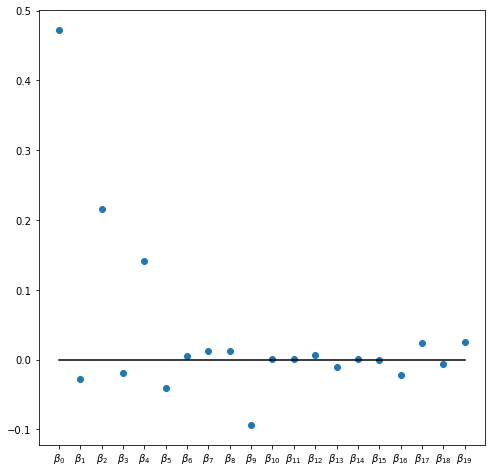

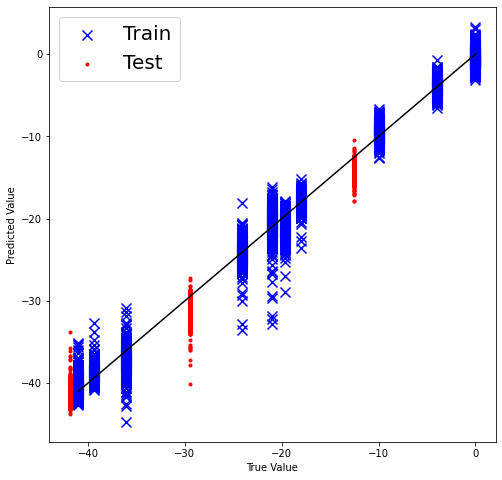

In [3]:
lr = CDMS_LR(X_train, y_train, X_test, y_test, x_mean, x_std, y_norm, mode="LR")
lr.do_LR()
rmse_lr_train, rmse_lr_test, coeffs_opt_LR = lr.model_eval()

Let's also perform the hyperparameter scan for Ridge and Lasso Regression, the same way we did that in the previous notebook.

/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7426137716328887, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3821404238626043, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17088124378827185, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objectiv

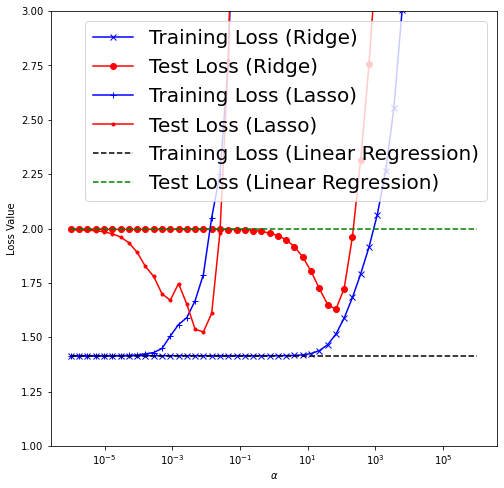

Minimum Test Loss for Ridge:  1.6291215002258335
Alpha for Minimum Test Loss for Ridge:  68.66488450042998
Minimum Test Loss for Lasso:  1.5244455151398457
Alpha for Minimum Test Loss for Lasso:  0.008286427728546842


In [4]:
alphas = np.logspace(-6, +6, 50)
RMSE_train_Ridge = []
RMSE_test_Ridge = []
RMSE_train_Lasso = []
RMSE_test_Lasso = []
min_ridge_loss = 99.0
min_lasso_loss = 99.0
alpha_opt_ridge = 0.
alpha_opt_lasso = 0.
coeffs_opt_ridge = []
coeffs_opt_lasso = []

for ii, alpha in enumerate(alphas):
    lr = CDMS_LR(X_train, y_train, X_test, y_test, x_mean, x_std, y_norm, mode="Ridge", alpha=alpha)
    lr.do_LR()
    etr, etst, coeffs = lr.model_eval(do_plot=False)
    RMSE_train_Ridge.append(etr)
    RMSE_test_Ridge.append(etst)
    if etst < min_ridge_loss:
        min_ridge_loss = etst
        alpha_opt_ridge = alpha
        coeffs_opt_ridge = coeffs
    lr = CDMS_LR(X_train, y_train, X_test, y_test, x_mean, x_std, y_norm, mode="Lasso", alpha=alpha)
    lr.do_LR()
    etr, etst, coeffs = lr.model_eval(do_plot=False)
    RMSE_train_Lasso.append(etr)
    RMSE_test_Lasso.append(etst)
    if etst < min_lasso_loss:
        min_lasso_loss = etst
        alpha_opt_lasso = alpha
        coeffs_opt_lasso = coeffs

fig = plt.figure(figsize=(8,8))
plt.plot(alphas, RMSE_train_Ridge, marker='x', color='b', label='Training Loss (Ridge)')
plt.plot(alphas, RMSE_test_Ridge, marker='o',  color='r', label='Test Loss (Ridge)')
plt.plot(alphas, RMSE_train_Lasso, marker='+', color='b', label='Training Loss (Lasso)')
plt.plot(alphas, RMSE_test_Lasso, marker='.', color='r', label='Test Loss (Lasso)')

plt.plot(alphas, [rmse_lr_train]*len(alphas), color='k', linestyle='--', label='Training Loss (Linear Regression)')
plt.plot(alphas, [rmse_lr_test]*len(alphas), color='g', linestyle = '--', label='Test Loss (Linear Regression)')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel("Loss Value")
plt.legend(fontsize = 20)
plt.ylim([1.0, 3.0])
plt.show()

print("Minimum Test Loss for Ridge: ", min_ridge_loss)
print("Alpha for Minimum Test Loss for Ridge: ", alpha_opt_ridge)

print("Minimum Test Loss for Lasso: ", min_lasso_loss)
print("Alpha for Minimum Test Loss for Lasso: ", alpha_opt_lasso)

In principle, the codeblocks above should become a part of the model repository. However, we are demonstrating them separately in this notebook for demonstration purposes. You can see that the `src` subdirectory also has a script `trainNsave.py` which performs the exact same job as shown in the code above, as well as some of the things we show below. 

Now, we want to *publish* the trained models we have at hand, i.e. we want to make them available in a way so that an external user can directly use them without retraining them. Since we are dealing with a rather simple model here where the most complicated data structure is essentially a numpy array. Hence, we can simply store the relevant model information as dictionary type object in a **JSON** file, which is both human and machine readable.

In [5]:
import json

model_info ={}

model_info['normalization'] = {'x_mean':list(x_mean), 
                               'x_std':list(x_std), 
                               'y_norm':y_norm}
model_info['test_data'] = {'labels':[-12.502, -29.5, -41.9]}
model_info['Linear_Regression']={'coeffs':list(coeffs_opt_LR)}
model_info['Ridge_Regression'] ={'alpha':alpha_opt_ridge,
                                 'coeffs':list(coeffs_opt_ridge)}
model_info['Lasso_Regression'] ={'alpha':alpha_opt_lasso,
                                 'coeffs':list(coeffs_opt_lasso)}

json.dump(model_info, open("models/model_01_CDMS-LR/model-info.json","w"), indent=3)

The codeblock above dumps a number of relevant information for the models we want to save. For someone who wants to use this model to make an inference should be able to use this information to perform all the necessary tasks- from data normalization to model predictions. However, publishing the model alone is not enough! We need relevant metadata, descriptive information about what the model is doing, what different keywords in the published trained model indicate. We can do it in a separate JSON file.

In [6]:
model_metadata = {}

model_metadata['genInfo'] = '''
This set of models represents the trained parameters for a Linear Regression model for determining the impact location on a superCDMS prototype based on timing measurements. 
'''
model_metadata['data_ID']  = 'https://github.com/FAIR-UMN/FAIR-UMN-CDMS/blob/main/data/processed_csv/processed_combined.csv?raw=true'
model_metadata['model_ID'] = ''
model_metadata['keywords'] = [key for key in model_info.keys()]
model_metadata['model_keys'] = {
    'normalization':{
        'description': 'Vectors for data standardization',
        'entries':{'x_mean': 'Mean value of input features',
                   'x_std':  'St. deviation of input features',
                   'y_norm': 'Normalization constant for target variable'
                  }
    },
    'test_data':{
        'description': 'How the test_data has been isolated',
        'entries':{'labels': 'Data label for target variable to separate test dataset'
                  }
    },
    'Linear_Regression':{
        'description': 'Model parameters for a simple linear least squared model',
        'entries':{'coeffs': 'List of linear coefficients for input features, the first entry represents the intercept'
                  }
    },
    'Ridge_Regression':{
        'description': 'Model parameters for a linear least squared model with Ridge regularization',
        'entries':{'coeffs': 'List of linear coefficients for input features, the first entry represents the intercept',
                   'alpha': 'Value of regularization strength determining model hyperparameter'
                  }
    },
    'Lasso_Regression':{
        'description': 'Model parameters for a linear least squared model with Lasso regularization',
        'entries':{'coeffs': 'List of linear coefficients for input features, the first entry represents the intercept',
                   'alpha': 'Value of regularization strength determining model hyperparameter'
                  }
    },
}

json.dump(model_metadata, open("models/model_01_CDMS-LR/model-metadata.json","w"), indent=3)

Please note the design of the metadata, which besides providing a generic description of the model also gives necessary Identifiers for the model and the dataset associated with it. For this pedagogical exercise, the identifiers we are using are URLs for github repositories. However, in any application they should be replaced by more persisent URIs as we discussed in previous notebooks. Also, the metadata has a key called `model_keys` that lists the exact dictionary keys of the trained model in `model-info.json`. Each entry under this keyword is also a dictionary with keys identical to the ones available in the model info file. This is to enable a directly machine readable interface for the trained models by allowing the necessary keys from metadata.

All of this is made available via the `trainNsave.py` script in the model directory. You can run the script directly to train the model, as well as save the trained models and the corresponding metadata. To run that script from the current notebook, we use the following codeblock.

RMSE from train data = 1.4152108662142222
RMSE from test data = 1.9964235488702617


trainNsave.py:10: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  myDL = DL('../data/CDMS_Dataset.csv', sep=',')


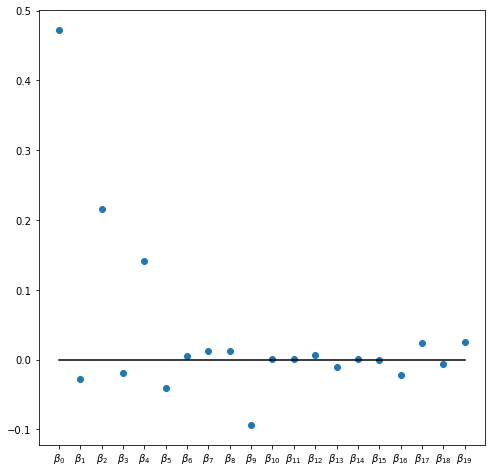

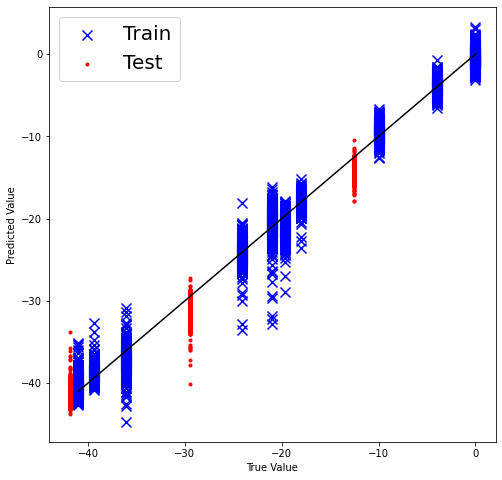

/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7426137716328887, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3821404238626043, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17088124378827185, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objectiv

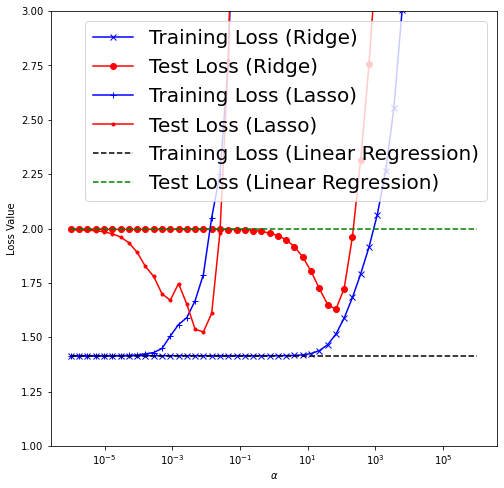

Minimum Test Loss for Ridge:  1.6291215002258335
Alpha for Minimum Test Loss for Ridge:  68.66488450042998
Minimum Test Loss for Lasso:  1.5244455151398457
Alpha for Minimum Test Loss for Lasso:  0.008286427728546842


In [7]:
import os
cwd = os.getcwd()
os.chdir('models/model_01_CDMS-LR/src')
%run -i 'trainNsave.py'
os.chdir(cwd)

Now finally, we want to have a dedicated example of *inference script*, that illustrates how to use the trained models for the purpose of running inference on some sample dataset. We put the code in the script `inference.py`. You can inspect the code there, the idea is to obtain the model parameters from the `model-info.json` file and use them to run regression.

RMSE from train data = 1.5666424452493621
RMSE from test data = 1.5156443931374577


inference.py:20: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  myDL = DL('../data/CDMS_Dataset.csv', sep=',')


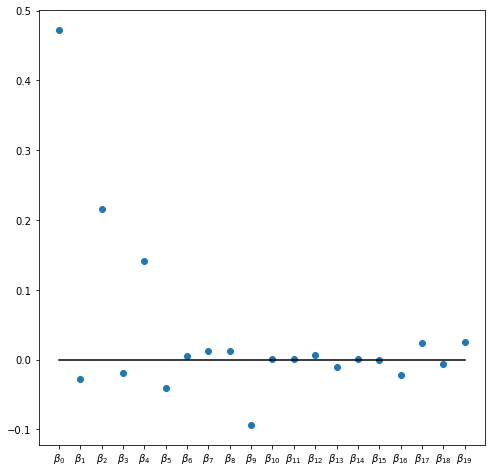

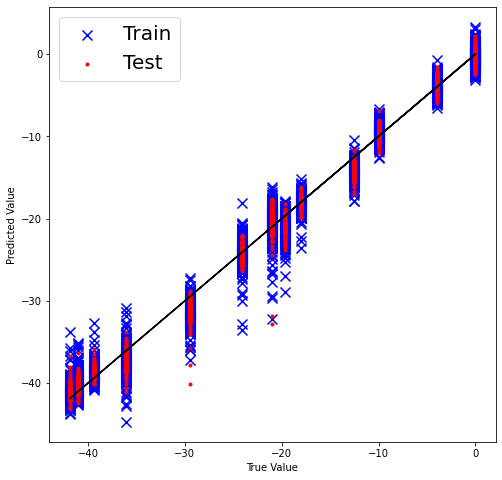

RMSE from train data = 1.5475569028569867
RMSE from test data = 1.5064596368624672


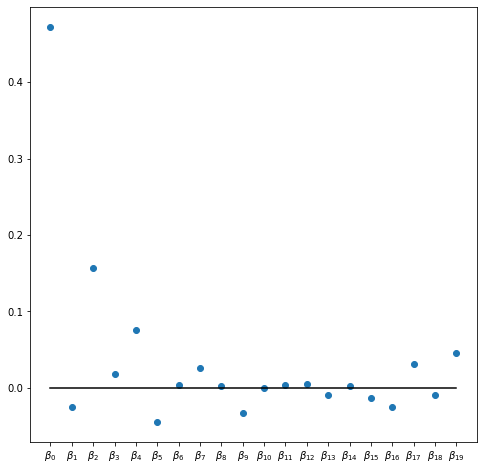

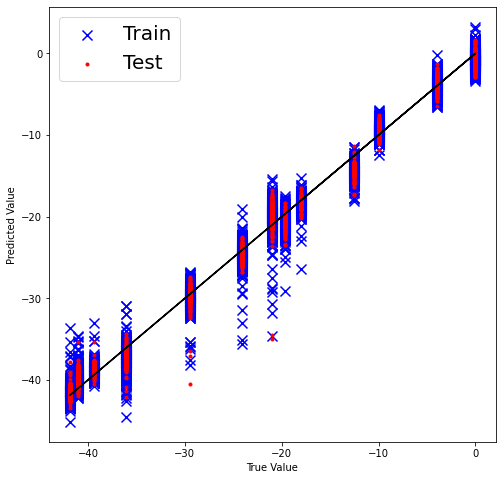

RMSE from train data = 1.7437976660288403
RMSE from test data = 1.7037315183973494


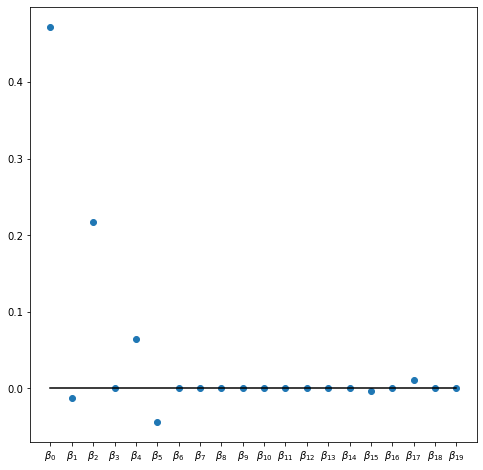

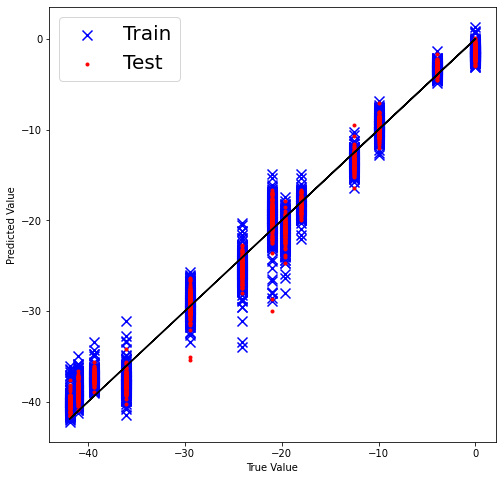

In [8]:
cwd = os.getcwd()
os.chdir('models/model_01_CDMS-LR/src')
%run -i 'inference.py'
os.chdir(cwd)